# New classification: Sequential Model

In [394]:
import numpy as np
import pandas as pd 
import os
import itertools
import os
import re

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models

# fetch data

In [395]:
path = "C:/Users/bsooral/PycharmProjects/topicDetectFlask/data/20news-18828"
allFolders = os.listdir(path)
df = []
for fldr in allFolders:
    allFiles = os.listdir(path+"/"+fldr)
    for fls in allFiles:
        with open(path+"/"+fldr+"/"+fls, "r") as f:
            d = {"category":str(fldr),"text":f.read()}
        df.append(d)
data = pd.DataFrame(df)
data = data.sample(frac = 1).reset_index(drop=True)
data.head()

,category,text
0,rec.motorcycles,From: tony@morgan.demon.co.uk (Tony Kidson)\nS...
1,soc.religion.christian,From: hudson@athena.cs.uga.edu (Paul Hudson Jr...
2,alt.atheism,Subject: Re: Ancient islamic rituals\nFrom: bo...
3,sci.space,From: henry@zoo.toronto.edu (Henry Spencer)\nS...
4,rec.sport.baseball,From: jonesk@ur.msstate.edu\nSubject: re: Mo S...


In [396]:
data3 = pd.read_json("C:/Users/bsooral/PycharmProjects/topicDetectFlask/data/News_Category_Dataset_v2.json", lines = True) 

In [397]:
data3.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [398]:
data3["text"] = data3.headline+data3.short_description

In [399]:
data2 = pd.read_csv("C:/Users/bsooral/PycharmProjects/topicDetectFlask/bbc-text.csv")
frames = [data, data2,data3[["category","text"]]]
data = pd.concat(frames)
data = data.sample(frac = 1).reset_index(drop=True)
data.category = data.category.apply(lambda x: x.lower())
data.head()

,category,text
0,politics,These Inmates Did A Facebook Live From The Cou...
1,politics,Obama To Visit Las Vegas As Immigration Moves ...
2,religion,Catholic Women React to Pope Francis's Latest ...
3,sports,Eli Manning Looked Sad Last Night And The Inte...
4,wellness,How Yoga Helped Me Transcend Sexual ViolenceTh...


## Cleaning

In [400]:
def replace_cat(y):
    if y == 'talk.politics.mideast' or y == 'talk.politics.guns' or y \
        == 'talk.politics.misc':
        return 'politics'
    if y == 'rec.sport.hockey' or y == 'rec.sport.baseball':
        return 'sports'
    if y == 'tech' or y == 'sci.med' or y == 'science' or y \
        == 'sci.space' or y == 'sci.crypt' or y == 'sci.electronics':
        return 'science and tech'
    if y == 'comp.os.ms-windows.misc' or y == 'comp.sys.mac.hardware' \
        or y == 'comp.sys.ibm.pc.hardware' or y == 'comp.windows.x' \
        or y == 'comp.graphics':
        return 'computers'
    if y == 'rec.motorcycles' or y == 'rec.autos':
        return 'automobiles'
    if y == 'alt.atheism' or y == 'talk.religion.misc' or y \
        == 'soc.religion.christian':
        return 'religion'
    if y == 'culture & arts' or y == 'arts & culture':
        return 'arts & culture'
    if y == 'black voices' or y == 'latino voices':
        return 'arts & culture'
    if y == 'misc.forsale':
        return 'misc'

data['category'] = data['category'].apply(lambda x: replace_cat(x))

In [401]:
data.category.unique()

array([None, 'computers', 'politics', 'arts & culture',
       'science and tech', 'religion', 'sports', 'automobiles', 'misc'],
      dtype=object)

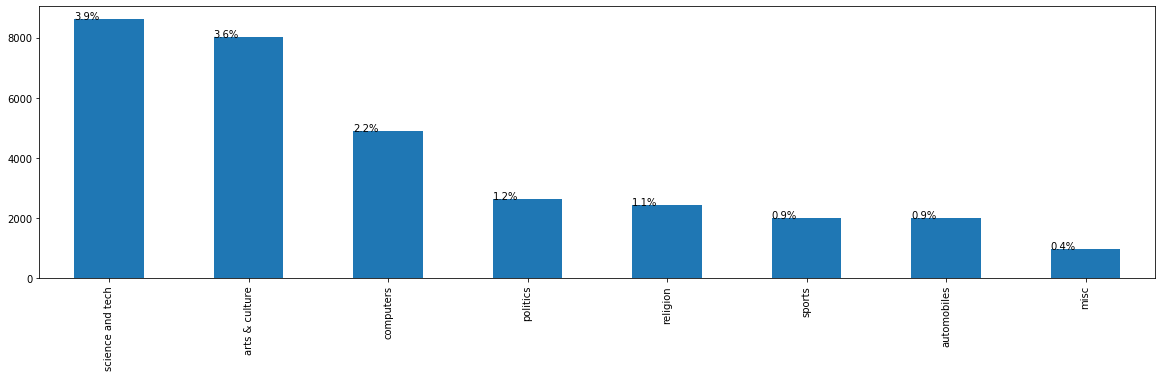

In [402]:
news_count = data['category'].value_counts()
news_percent = [len(data[data['category'] == news_cat]) / len(data) * 100 for news_cat in news_count.index]

ax = news_count.plot(kind='bar', figsize=(20, 5))
for idx, p in enumerate(ax.patches):
    h = p.get_height()
    x, y = p.get_xy()
    ax.annotate('{:.1f}%'.format(news_percent[idx]), (x, y + h + 0.01))

In [403]:
import re

from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
stop_words = set(stopwords.words("english"))

def cleanUpSentence(r, stop_words = stop_words):
    r = re.sub(strip_special_chars, " ", r.lower())
    r = re.sub('[0-9]+', ' ', r)
    if stop_words is not None:
        words = word_tokenize(r)
        filtered_sentence = []
        for w in words:
            w = lemmatizer.lemmatize(w)
            if ((w not in stop_words) and (len(w)<8) and (len(w)>2)):
                filtered_sentence.append(w)
        return " ".join(filtered_sentence)
    else:
        return r

In [404]:
#data["text"] = data["text"].apply(lambda x: cleanUpSentence(x))

In [405]:
#data.to_pickle("./data.pkl")
data = pd.read_pickle("./data.pkl")

In [406]:
max_words = 20000
max_len = 125

In [407]:
train_size = int(len(data) * .9)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

Train size: 750028
Test size: 83337


In [408]:
from sklearn.model_selection import train_test_split
data = data.sample(frac = 1).reset_index(drop=True)
train_text, test_text, train_cat, test_cat = train_test_split(data['text'].values, data['category'].values, test_size=0.2)

In [409]:
max_words = 20000
OOV_TOK = '<OOV>'
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data["text"]) # fit tokenizer to our training text data

In [410]:
x_train = tokenizer.texts_to_sequences(train_text)
x_test = tokenizer.texts_to_sequences(test_text)

In [411]:
from keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(x_train, maxlen=max_len, padding='pre')
x_test = pad_sequences(x_test, maxlen=max_len, padding='pre')

In [412]:
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (666692, 125)
x_test shape: (166673, 125)
y_train shape: (666692, 45)
y_test shape: (166673, 45)


# Embedding

In [413]:
vocab_size = len(tokenizer.word_index)+1

In [414]:
GLOVE_DIR = "C:/Users/bsooral/PycharmProjects/topicDetectFlask/glove.6B.300d.txt"
embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [415]:
embed_size = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embed_size))
absent_words = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1

# Modeling

In [416]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding

In [417]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length=max_len))
#model.add(Embedding(vocab_size, vector_dim, input_length=max_len))
model.add(LSTM(num_classes,activation="tanh",input_shape=(max_len, vector_dim), return_sequences = False))
model.add(Dense(num_classes,activation="softmax"))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

print("Model Summary")
print(model.summary())

Model Summary
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 125, 300)          32856600  
_________________________________________________________________
lstm_26 (LSTM)               (None, 45)                62280     
_________________________________________________________________
dense_25 (Dense)             (None, 45)                2070      
Total params: 32,920,950
Trainable params: 32,920,950
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=512, validation_split=0.2, verbose=1)

Train on 533353 samples, validate on 133339 samples
Epoch 1/10
177152/533353 [========>.....................] - ETA: 19:38 - loss: 2.2445 - accuracy: 0.4418

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
query = "The motherboard is one of the most important parts of a"
query = cleanUpSentence(query)
query = tokenizer.texts_to_sequences([query])
query = pad_sequences(query, maxlen=max_len, padding='pre')
prediction = model.predict(np.array(query))
text_labels = encoder.classes_ 
text_labels[np.argmax(prediction)]